In [1]:
from __future__ import division
from importlib import reload
from modules import * 
import csv
fig_savedir = '../data/figures/'

grid_params = {
    'y_height':   10,
    'x_width':    10,
    'walls':      False,
    'rho':        0,
    'maze_type':  'none',
    'port_shift': 'none'
}


agent_params = {
    'load_model':   True,
    'load_dir':     '../data/outputs/gridworld/MF{}{}training_rwd7_2.pt'.format(grid_params['x_width'],grid_params['y_height']),
    'action_dims':  6, #=len(maze.actionlist)
    'lin_dims':     500,
    'batch_size':   1,
    'gamma':        0.98, #discount factor
    'eta':          5e-4,
    'temperature':  1,
    'use_EC':       False,
    'cachelim':     100, # memory limit should be ~75% of #actions x #states
    'state_type':   'conv'
}

run_dict = {
    'NUM_EVENTS':   150,
    'NUM_TRIALS':   5000,
    'print_freq':   1/10,
    'total_loss':   [[],[]],
    'total_reward': [],
    'val_maps':     [],
    'policies':     [{},{}],
    'deltas':       [],
    'spots':        [],
    'vls':          []
}

[(5, 5)]


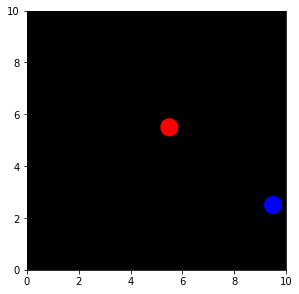

In [2]:
#make environment
maze = eu.gridworld(grid_params)
maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
env = eu.gymworld(maze) # openAI-like wrapper 

#update agent params dictionary with layer sizes appropriate for environment 
agent_params = sg.gen_input(maze, agent_params)
MF,opt = ac.make_agent(agent_params, freeze=False)
gp.make_env_plots(maze,env=True)


agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))

EC = ec.ep_mem(MF,agent_params['cachelim']) 
print(maze.rwd_loc)

In [3]:
for param_ in opt.param_groups:
    print(param_['lr'])

0.0005


In [4]:
print(maze.grid.shape)

(10, 10)


In [5]:
# write a function for runs with episodic mem and without -- take use_EC as a param
# assume just for conv inputs 
def run_trials(run_dict, use_EC, **kwargs):
    save_data  = kwargs.get('save', True)
    NUM_TRIALS = run_dict['NUM_TRIALS']
    NUM_EVENTS = run_dict['NUM_EVENTS']
    
    blocktime = time.time()
    
    if use_EC:
        EC.reset_cache()
        add_mem_dict = {} #dictionary of items which get put into memory cache
        
        run_dict['total_loss']   =  [[],[]]
        run_dict['total_reward'] = []
        run_dict['track_cs']     = [[],[]]
        run_dict['rpe']          = np.zeros(maze.grid.shape)
        
        reward    = 0
        timestamp = 0
        tslr      = np.nan_to_num(np.inf)
        
        for trial in range(NUM_TRIALS):
            trialstart_stamp = timestamp

            reward_sum   = 0
            v_last       = 0

            env.reset() 
            
            state = torch.Tensor(sg.get_frame(maze))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                #compute confidence in MFC
                if event in [0,1]:
                    MF_cs = EC.make_pvals(tslr,envelope=10)
                else: 
                    MF_cs = EC.make_pvals(tslr,envelope=10, pol_id = pol_flag, mfc=MF_cs)
                # pass state through EC module
                
                policy_, value_, lin_act_ = MF(state, temperature = 1)
                lin_act = tuple(np.round(lin_act_.data[0].numpy(),4))
                if event is not 0:
                    ec_pol = torch.from_numpy(EC.recall_mem(lin_act, timestamp, env=150))
                    candidate_policies = [policy_, ec_pol]
                    pol_choice = np.random.choice([0,1], p=[MF_cs, 1-MF_cs])
                    pol = candidate_policies[pol_choice]
                    if pol_choice == 0:
                        pol_flag = 'MF'
                    else:
                        pol_flag = 'EC'
                    choice, policy, value = ac.select_ec_action(MF, policy_, value_, pol)
                else:
                    choice, policy, value = ac.select_action(MF,policy_, value_)
                
                add_mem_dict['state'] = maze.cur_state
                #compute eligibility trace/rpe approximation
                delta = reward + agent_params['gamma']*value - v_last  
                run_dict['rpe'][maze.cur_state[1]][maze.cur_state[0]] = delta
                
                
                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)

                if event is not 0:
                    if reward == 1:
                        tslr = 0
                        delta = 25
                    else:
                        tslr += 1
                    
                    run_dict['track_cs'][0].append(tslr)
                    run_dict['track_cs'][1].append(MF_cs)
                
                MF.rewards.append(reward)
                
                
                add_mem_dict['activity']  = lin_act
                add_mem_dict['action']    = choice
                add_mem_dict['delta']     = delta
                add_mem_dict['timestamp'] = timestamp            
                
                EC.add_mem(add_mem_dict)#add event to memory cache
                
                # because we need to include batch size of 1 
                state = torch.Tensor(sg.get_frame(maze))
                reward_sum += reward

                v_last = value
                timestamp += 1

            p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)
            
            if save_data:
                #value_map = ac.generate_values(maze,MF)
                #run_dict['total_loss'][0].append(p_loss.data[0])
                #run_dict['total_loss'][1].append(v_loss.data[0])
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%10==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()

    else:
        run_dict['rpe'] = np.zeros(maze.grid.shape)
        run_dict['total_loss'] =  [[],[]]
        run_dict['total_reward'] = []
        for trial in range(NUM_TRIALS):
            reward_sum   = 0
            v_last       = 0
            track_deltas = []
            track_spots  = []
            visited_locs = []

            env.reset() 
            state = torch.Tensor(sg.get_frame(maze))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                policy_, value_ = MF(state, agent_params['temperature'])[0:2]
                choice, policy, value = ac.select_action(MF,policy_, value_)

                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)

                MF.rewards.append(reward)
                #compute eligibility trace/rpe approximation
                delta = reward + agent_params['gamma']*value - v_last  
                state = torch.Tensor(sg.get_frame(maze))
                run_dict['rpe'][maze.cur_state[1]][maze.cur_state[0]] = delta
                
                reward_sum += reward
                v_last = value

            p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)
            
            if save_data:
                #value_map = ac.generate_values(maze,MF)
                run_dict['total_loss'][0].append(p_loss.item())
                run_dict['total_loss'][1].append(v_loss.item())
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%100==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()

In [6]:
run_trials(run_dict, True) #false = mf only, true = w ec

../memory/episodic.py:66: RuntimeWarning: overflow encountered in cosh
  return np.round(1 / np.cosh(p / self.memory_envelope), 8)


KeyError: 'readable'

In [ ]:
#### run a bunch of trials to get rwds to average 
ec_sim = False
for i in range(2):
    print('-----\n',i)
    MF,opt = ac.make_agent(agent_params, freeze=False)
    if ec_sim:
        EC = ec.ep_mem(MF,agent_params['cachelim']) 
        run_trials(run_dict, True)
    else:
        run_trials(run_dict, False)
    with open('1000_1posttrain_mf.csv', 'a+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows([run_dict['total_reward']])
    csvFile.close()

In [ ]:
plt.plot(run_dict['total_reward'], label='r')
#plt.plot(run_dict['total_loss'][0], label='p')
#plt.plot(run_dict['total_loss'][1], label='v')
plt.legend(bbox_to_anchor=(1.1,1.1))


In [ ]:
#early_learn_mf_only = run_dict['total_reward']
#early_learn_w_ec = run_dict['total_reward']
#late_learn_mf_only = run_dict['total_reward']
#late_learn_w_ec = run_dict['total_reward']

In [ ]:
print(len(run_dict['total_reward']))

In [ ]:
fig, ax = plt.subplots(2,1, sharex = True, sharey=True)
ax[0].plot(early_learning_w_ec, 'b', alpha =0.7, label = 'With EC')
ax[0].plot(early_learn_mf_only, 'k--', alpha = 0.7, label="MF only")

ax[1].plot(late_learn_w_ec, 'r', label='With EC')
ax[1].plot(late_learn_mf_only, 'k--', alpha = 0.7, label ='MF only')

ax[0].legend(bbox_to_anchor = (1.0,.75))
ax[1].legend(bbox_to_anchor = (1.0,.75))
fig.savefig('compare.svg', format='svg')

In [ ]:
plt.imshow(rpe) 
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
cmap = plt.cm.Spectral_r
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap = cmap)

ax1 = fig.add_axes([0.04, 0, 0.85, 0.85])
axc = fig.add_axes([0.8, 0, 0.05, 0.85])

cb1 = colorbar.ColorbarBase(axc, cmap = cmap, norm = cNorm)
ax1.imshow(maze.grid, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle(maze.rwd_loc[0], 0.35, fc='w'))

for entry in compare_policies.keys():
    x = entry[0]
    y = entry[1]
    
    ec_policy = compare_policies[entry][1][0] - compare_policies[entry][0][0]
    action = np.argmax(ec_policy)
    prob = max(ec_policy)
    
    dx1, dy1, head_w, head_l = gp.make_arrows(action,prob)
    if prob > 1/4:
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(prob)
            ax1.arrow(x,y, dx1, dy1, head_width=0.3, head_length=0.2, color = colorVal1)
    else:
        pass

ax1.invert_yaxis()
plt.show()
plt.close()

In [ ]:
x = compare_policies[(7,5)][1]
for i in range(len(x)):
    plt.bar(np.arange(6)+(0.1*i), x[i], width = 0.1, alpha = 0.3)
    plt.bar(np.arange(6), np.ones(6)*0.16666667, width =0.1, color='k')
plt.show()

In [ ]:
print(len(DND.cache_list))
def cosine_sim(mem_dict, key, **kwargs):
    similarity_threshold = kwargs.get('threshold', 0.9)

    mem_cache = np.asarray(list(mem_dict.keys()))
    print(mem_cache.shape)
    entry = np.asarray(key)

    mqt = np.dot(mem_cache, entry)
    norm = np.linalg.norm(mem_cache, axis=1) * np.linalg.norm(entry)

    cosine_similarity = mqt / norm

    index = np.argmax(cosine_similarity)
    similar_activity = mem_cache[index]
    if max(cosine_similarity) >= similarity_threshold:
        return similar_activity, index, max(cosine_similarity)

    else:
        # print('max memory similarity:', max(cosine_similarity))
        return [], [], max(cosine_similarity)

def make_pvals(p, **kwargs):
    envelope = kwargs.get('envelope', 50)
    return np.round(1 / np.cosh(p / envelope),8)

def softmax(x, T=1):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp((x - np.max(x))/T)
    return e_x / e_x.sum(axis=0) 


In [ ]:
state_key, ind, max_cs = cosine_sim(DND.cache_list, sts[0])
print('sim', max_cs)
memory = np.nan_to_num(DND.cache_list[tuple(state_key)][0])
deltas = memory[:,0]
print(deltas)
rec_times = memory[:,1]
print("rtimes",rec_times)
times        = abs(timestep - memory[:,1])
print('tiems', times)
pv =make_pvals(times)
print(pv)

mult = np.multiply(deltas, pv)
print(softmax(max_cs*mult))

In [ ]:

for i in sts[0:10]:
    timestep = 1000
    a = DND.recall_mem(key=i,timestep=timestep,env=100)
    print(a,"----\n")

In [ ]:
cs =['r','g','b','c', 'y','pink']
'''
r = list(self.cache_list.keys())
g = [t for e, t in self.cache_list.values()]
b = lp = persistence_.index(min(persistence_))
c = old_activity = cache_keys[lp]
y = del self.cache_list[old_activity]
'''
plt.figure()
for i in range(len(EC.stupid_df)):
    xs = np.arange(len(EC.stupid_df[i]))
    ys = EC.stupid_df[i]
    
    plt.scatter(xs, ys, c=cs[i], alpha=0.3)
plt.ylim([-0.00002,0.00002])
plt.show()

In [ ]:
plt.figure(1)
plt.plot(run_dict['total_reward'])
plt.ylim([0,run_dict['NUM_EVENTS']])
 
plt.figure(2)
plt.plot(run_dict['total_loss'][0], label = 'pol')
plt.plot(run_dict['total_loss'][1], label = 'val')
plt.legend(loc=0)
plt.show()
plt.close()
#gp.print_value_maps(maze, run_dict['val_maps'], maps=0, val_range=(-1,50), save_dir=fig_savedir, title='Value Map')

In [ ]:
ac.torch.save(MF,agent_params['load_dir'])